**CONSTANT HEIGHT STM IMAGES**
------------------------------


Theory Background
-----------------

Prediction of STM images requires a knowledge of the **electronic structure** of the molecule and a theory of how STM works.

The standard theory of how STM works is based on the Tersoff-Hammann aproximation (https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.50.1998):
**the tunneling current is proportional to the local density of states (LDOS)**:

$$
I(\vec{r}, V) \propto \int_0^V LDOS(\vec{r}, E_f - V + \epsilon) \,d\epsilon\
$$
The LDOS at a certain energy is calculated from the electron density, computed as $\psi(\vec{r}) \psi^*(\vec{r})$, considering only  wavefunctions at that energy.

The value of the tip bias V determines **which states are explored**:  

$V = V_{tip} - V_{sample} > 0$ : sample electrons go to the tip, so the images **show occupied states**.

$V = V_{tip} - V_{sample} < 0$ : tip electrons go to the sample, so the images **show unoccupied states**.

In summary, to compute constant height STM images, we need:

1.- Obtain atomic coordinates (for example, from a previous geometry optimization calculation)

2.- Compute the eigenstates (wavefunction coefficients) and eigenvalues (energies). We will use **SIESTA** for this.

3.- Compute electron density of selected states and compute the STM current $I(\vec{r}, V)$ for any point in space $\vec{r}$ (at a constant height $z$), given the voltage bias $V$. We will use **python** for this.

$$
I(\vec{r}, V) \propto \int_0^V \sum_{i} \left[n(-V + E, \epsilon_i) *  \psi_i(\vec{r}) \psi_i^*(\vec{r})\right] \,dE\
$$

Python implementation of STM simulation
---------------------------------------
We first import of required libraries

In [1]:
import sisl
from sisl import *
import sisl.viz
import numpy as np
import matplotlib.pyplot as plt

## Analysis of SIESTA Results
**Load SIESTA Calculation**

Once the SIESTA run has finished, to load SIESTA results into python you can do:

```python
sisl.get_sile("path/to/my/file.fdf").read_hamiltonian()
```

as we have done in previous lab sessions.

In [2]:
fdf = get_sile("../run/stm.fdf")

In [4]:
H = fdf.read_hamiltonian()

In [5]:
molec = H.geometry

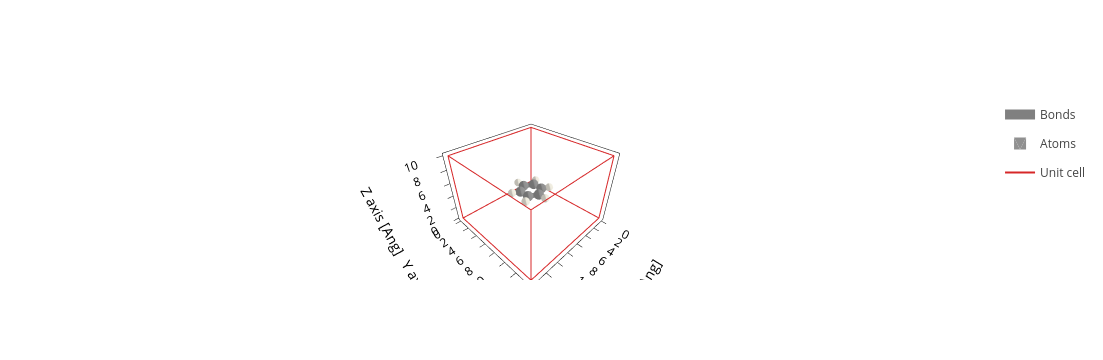

In [13]:
molec.plot()

## Eigenstates

Once you have a hamiltonian, you can get all Eigenstates with `H.eigenstate()`. Then you can loop this object to get each individual eigenstate. 
- Each eigenstate has its energy stored under the `.eig` property.
- We can find the HOMO and LUMO.
- We can use the `.dos`  method to obtain the density of states DOS(E).
- In sisl we can plot pdos directly in a given Energy range with something like `H.plot.pdos(data_Erange=[-10,10],nE=1200,Erange=[-10,10]) `

In [8]:
es=H.eigenstate()

In [9]:
es.eig

array([-16.35150932, -13.70315996, -13.7018968 , -10.12421723,
       -10.12065492,  -8.02521474,  -6.57489207,  -6.18072945,
        -5.51805144,  -5.51223221,  -4.23300746,  -3.64952613,
        -3.64643618,  -1.65419189,  -1.65214275,   3.26588369,
         3.26873903,   5.13687139,   6.14892413,   6.15040046,
         6.90309496,   6.90806096,   6.98447225,   7.70269782,
         8.75225549,   9.72902985,   9.77592872,  10.14279863,
        10.14453041,  10.58057982,  10.58888382,  10.93550912,
        10.93641361,  12.47362655,  12.47753505,  12.49777579,
        13.27327676,  13.27752766,  13.45582521,  13.55743962,
        13.55994065,  14.66225094,  15.81451242,  16.80902426,
        16.81008417,  17.62476669,  17.65379279,  17.65765812,
        18.59946606,  18.96315438,  18.97268342,  20.69361817,
        21.04243315,  22.43923831,  22.43971323,  23.0466846 ,
        23.05210273,  23.31688887,  23.3209072 ,  25.59271793,
        25.61647082,  26.66740162,  27.17719356,  27.80

In [10]:
idx_lumo = (es.eig > 0).nonzero()[0][0] #trick to obtain the LUMO as first positive eigenvalue

In [11]:
print(idx_lumo)

15


In [12]:
print("HOMO E=",es.eig[idx_lumo-1]," eV")
print("LUMO E=",es.eig[idx_lumo]," eV")

HOMO E= -1.6521427535465387  eV
LUMO E= 3.265883686603376  eV


-----------------------------------------------------------------------------------
## Plotting Local Density of States

Create a grid and fill the grid with LDOS

**To compute wavefunctions on the grid:**

To compute $\psi (\vec{r})$ you need three things.

1. **The eigenstate coefficients.** Once you have a hamiltonian, you can get all of them with `H.eigenstate()`. Then you can loop this object to get each individual eigenstate. Each eigenstate has its energy stored under the `.eig` property.
2. **A grid of points in space.** You can create one with `sisl.Grid(geometry, shape=(100, 100, 100))`. This will create a grid of $100x100x100$ points within the cell of your geometry.
3. **A function to project the wavefunction into the grid.** The eigenstate object has a `wavefunction` method ([docs](https://zerothi.github.io/sisl/api/generated/sisl.physics.electron.EigenstateElectron.html#sisl.physics.electron.EigenstateElectron.wavefunction)) that will project the wavefunction into an already initialized grid.
4. Once you have the wavefunction, you can calculate the electron density $\psi_i(\vec{r}) \psi_i^*(\vec{r})$.
5. The result can be saved in a '.cube' file and plotted with VMD 

Remember that we have done this already on the first SIESTA lab, with a water molecule and with $C_{60}$.


In [14]:
g = Grid(0.2, lattice=molec.lattice)  #defines a grid matching with our system

Save a state (for example, LUMO) in cube file

In [15]:
es[idx_lumo].wavefunction(g)
g.write('LUMO.cube')

g.fill(0) # reset the grid values to 0

Save Electron Density

In [16]:
g2 = Grid(0.2, lattice=molec.lattice) 

In [17]:
es[idx_lumo].wavefunction(g)
g2=g*g.grid.conj() 
g2.write('LUMOdens.cube')
g2.fill(0) # reset the grid values to 0

In [20]:
es[14].wavefunction(g)
g2=g*g.grid.conj() 
g2.write('state_dens.cube')
g2.fill(0) # reset the grid values to 0

We can easily save the electron density including a range of states

In [18]:
Gt = Grid(0.2, lattice=molec.lattice) 
for n in range(idx_lumo-4,idx_lumo):
    print("adding state",n)
    g.fill(0)
    es[n].wavefunction(g)
    Gt = Gt + g*g.grid.conj()
Gt.write('several_states.cube')
Gt.fill(0)

    

adding state 11
adding state 12
adding state 13
adding state 14


# STM images #

**Remember**: The value of the tip bias V determines **which states are explored**:  

$V = V_{tip} - V_{sample} > 0$ : sample electrons go to the tip, so the images **show occupied states**.

$V = V_{tip} - V_{sample} < 0$ : tip electrons go to the sample, so the images **show unoccupied states**.

Now we can create a function `STM_grid(H, V)` that creates a grid adding all the states that contribute to the electron density $\psi_i(\vec{r}) \psi_i^*(\vec{r})$ relevant to the STM image.

The `STM_grid(H, V)` function need the Hamitonian (the object `H`) and the value of the voltage `V`.

In [26]:
def STM_grid(H, V):
    gridT = sisl.Grid((300, 300, 300), geometry=molec)
    grid = sisl.Grid((300, 300, 300), geometry=molec)
    gridT.fill(0)
    E=-V
    for i in range(0,len(es)):
        #Negative V: electrons go from tip to sample filling unoccupied states from 0 to E
        if 0<es[i].eig<E:    
            grid.fill(0)
            print("adding state",i)
            es[i].wavefunction(grid)
            GT=grid*grid.grid.conj()
            gridT=gridT+GT
        #Positive V: electrons with energies between E and 0 leave the sample and go to the tip
        if E<es[i].eig<0:    
            grid.fill(0)
            print("adding state",i)
            es[i].wavefunction(grid)
            GT=grid*grid.grid.conj()
            gridT=gridT+GT 
    result=gridT
    return result

Calculate and save data. IN VMD you can use isosurface or Volume slice representations

In [28]:
V=STM_grid(H, 2)

adding state 13
adding state 14


In [29]:
V.write('STM_2Volt.cube')

In [24]:
V=STM_grid(H, -5)
V.write('STM_m5Volt.cube')

adding state 15
adding state 16
